All moved to [notebook](https://github.com/nnkennard/lab-notebook/blob/master/08/2021-08-14.md)

In [1]:
import collections
import itertools
import glob
import json
import pandas as pd
import seaborn as sns

In [2]:
def get_annotator(annotation):
    return annotation["metadata"]["anno"]

def get_rebuttal_alignments(annotation):
    return [set(x["labels"]["alignments"]) for x in annotation["rebuttallabels"]]

dataset_path = "/Users/nnayak/Downloads/05-16-provisional-emnlp-release-unsplit/"

results = collections.defaultdict(list)
adjudicated_results = collections.defaultdict(list)
all_results = collections.defaultdict(list)



for filename in glob.glob(dataset_path + "/*"):
    with open(filename, 'r') as f:
        obj = json.load(f)
    review = obj["metadata"]["review"]
    if get_annotator(obj) == 'anno0':
        adjudicated_results[review].append(obj)
    else:
        results[review].append(obj)
    all_results[review].append(obj)


In [3]:
matches = []
partial_matches = []
js_distances = []

class OverlapType(object):
    BOTH_NONE = "Agree none"
    ONE_NONE = "Disagree none"
    PARTIAL = "Partial match"
    NO_OVERLAP = "No overlap"
    EXACT = "Exact match"
    
    ALL = [
        EXACT,
    BOTH_NONE,
    PARTIAL,
    ONE_NONE,
    NO_OVERLAP,
    ]

def js_distance(set1, set2):
    return len(set1.intersection(set2))/len(set1.union(set2))

overlap_counter = collections.Counter()
exact_counter = collections.Counter()

for review, annotations in results.items():
    if len(annotations) == 1:
        continue
    else:
        annotators = [get_annotator(x) for x in annotations]
        for annotation_1, annotation_2 in itertools.combinations(annotations, 2):
            for ali_1, ali_2 in zip(get_rebuttal_alignments(annotation_1), get_rebuttal_alignments(annotation_2)):
                if not (ali_1.union(ali_2)):
                    overlap_counter[OverlapType.BOTH_NONE] += 1
                elif not ali_1 or not ali_2:
                    overlap_counter[OverlapType.ONE_NONE] += 1
                else:
                    if ali_1 == ali_2:
                        overlap_counter[OverlapType.EXACT] += 1
                        exact_counter[len(ali_1)] += 1
                    elif not (ali_1.intersection(ali_2)):
                        overlap_counter[OverlapType.NO_OVERLAP] += 1
                    else:
                        overlap_counter[OverlapType.PARTIAL] += 1
                        js_distances.append(js_distance(ali_1, ali_2))

barplot_dicts = []
for k, v in overlap_counter.items():
    barplot_dicts.append({
        "Overlap type": k,
        "Count": v
    })
overlap_type_df = pd.DataFrame.from_dict(barplot_dicts)

print(overlap_type_df)

    Overlap type  Count
0     Agree none    256
1    Exact match   1227
2     No overlap    204
3  Partial match    711
4  Disagree none    119


<AxesSubplot:xlabel='Overlap type', ylabel='Count'>

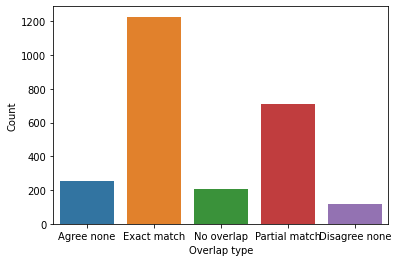

In [5]:
#overlap_type_df
sns.barplot(data=overlap_type_df, x = "Overlap type", y="Count")

<AxesSubplot:ylabel='Count'>

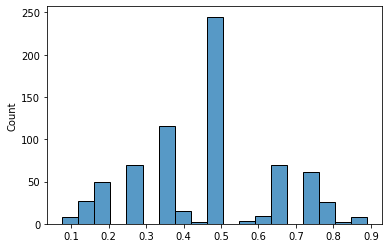

In [6]:

sns.histplot(js_distances)

In [7]:
class ContextType(object):
    NO_CONTEXT = "No context"
    GLOBAL_CONTEXT = "Global context"
    SINGLE_SENTENCE = "Single sentence"
    CONTIGUOUS_SENTENCES = "Contiguous sentences"
    NONCONTIGUOUS_SENTENCES = "Non-contiguous sentences"
    MYSTERIOUS = "Mysterious"
    
def is_contiguous(alignments):
    relevant_range = list(range(min(alignments), max(alignments) + 1))
    return relevant_range == list(sorted(alignments))

for review, annotations in adjudicated_results.items():
    for annotation in annotations:
        if not get_annotator(annotation) == "anno0":
            continue
        for label in annotation["rebuttallabels"]:
            alignment = label["labels"]["alignments"]
            if not alignment:
                context_counter[ContextType.MYSTERIOUS] += 1
            elif len(alignment) == 1:
                context_counter[ContextType.SINGLE_SENTENCE] += 1
            else:
                if is_contiguous(alignment):
                    context_counter[ContextType.CONTIGUOUS_SENTENCES] += 1
                else:
                    context_counter[ContextType.NONCONTIGUOUS_SENTENCES] += 1


In [8]:
# Count double annotations
adjudicated_test_dir = "/Users/nnayak/Downloads/0517_split_2/test/"

annotators = collections.Counter()
for filename in glob.glob(adjudicated_test_dir+"/*"):
    annotator = filename.split(".")[-2]
    annotators[annotator] += 1

#print(annotators, sum(annotators.values()))

In [9]:
j = collections.defaultdict(lambda:collections.Counter())

for example in sum(all_results.values(), []):
    review_coarse_labels = [label["labels"]["coarse"] for label in example["reviewlabels"]]
    for rebuttal_label in example["rebuttallabels"]:
        coarse = rebuttal_label["labels"]["responsetype"]
        for aligned_idx in rebuttal_label["labels"]["alignments"]:
            j[coarse][review_coarse_labels[aligned_idx]] += 1
            
print(j)

defaultdict(<function <lambda> at 0x130224700>, {'done_manu_Yes': Counter({'Evaluative': 959, 'Request': 925, 'Fact': 278, 'Structuring': 133, 'Other': 14, 'Social': 5, '': 1}), 'done_manu_No': Counter({'Request': 62, 'Evaluative': 52, 'Fact': 23, 'Structuring': 6, 'Social': 1}), 'mitigate-criticism': Counter({'Evaluative': 694, 'Request': 117, 'Fact': 106, 'Structuring': 48, 'Other': 7}), 'answer': Counter({'Request': 4195, 'Evaluative': 3263, 'Fact': 1234, 'Structuring': 431, 'Other': 148, 'Social': 40}), 'reject-criticism': Counter({'Evaluative': 2143, 'Fact': 607, 'Request': 287, 'Structuring': 279, 'Other': 50}), 'concede-criticism': Counter({'Evaluative': 482, 'Request': 283, 'Fact': 140, 'Structuring': 75, 'Other': 12, 'Social': 2}), 'future': Counter({'Evaluative': 171, 'Request': 147, 'Fact': 59, 'Structuring': 22, 'Other': 8, 'Social': 1}), 'followup': Counter({'Evaluative': 40, 'Request': 26, 'Fact': 4, 'Structuring': 4}), 'structuring': Counter({'Evaluative': 1367, 'Request

In [10]:
print(len(j))

22


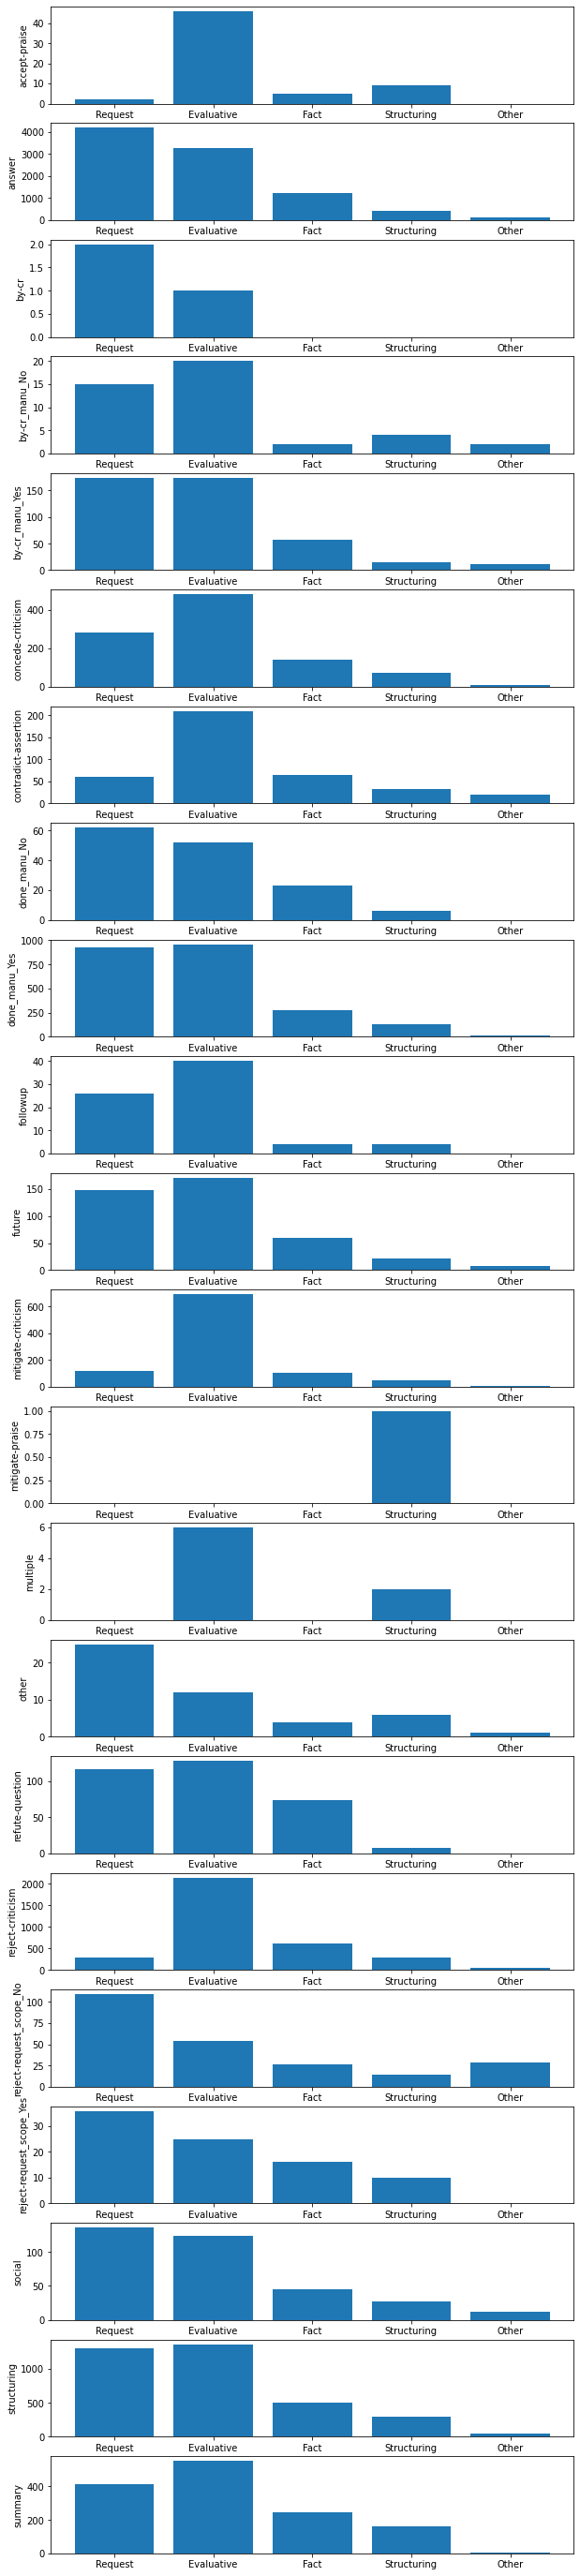

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=22, ncols=1, figsize=(10,50))

review_types = "Request Evaluative Fact Structuring Other".split()

for i, key in enumerate(sorted(j.keys())):

    vals = j[key]
#     print(vals)
#     print(i, key)
    axes[i].bar(review_types, [vals[i] for i in review_types])
    axes[i].set_ylabel(key)


In [12]:
for example in sum(all_results.values(), []):
    for i, rebuttal_label in enumerate(example["rebuttallabels"]):
        if rebuttal_label["labels"]["responsetype"] == "followup":
            print(example["rebuttal"][i]['sentence'])

- Could you be more specific on what do you expect for "larger studies" and "general study”?  This will be helpful for improving our work.
- Could you be more specific on what do you expect for "larger studies" and "general study”?  This will be helpful for improving our work.
- Could you be more specific on what do you expect for "larger studies" and "general study”?  This will be helpful for improving our work.
> We are not sure if we understand this completely.
We believe our results can inspire other researcher’s theoretical research.
If the reviewer remains concerned by a lack of novelty, we would be grateful if he/she could provide specific references so that we can compare them in detail with the DFW algorithm.
If the reviewer remains concerned by a lack of novelty, we would be grateful if he/she could provide specific references so that we can compare them in detail with the DFW algorithm.
We are not sure why you conclude this point.
And as stated in the paper, the design of Ta

In [13]:
import csv

combis = collections.defaultdict(lambda:collections.Counter())


agrees = collections.defaultdict(lambda:collections.Counter())
disagrees = collections.defaultdict(lambda:collections.Counter())

total_sentence_count = collections.Counter()

FIELDS = "annotators label_type label_1 label_2 review_id sent_index sentence".split()
DisagreementSentence = collections.namedtuple("DisagreementSentence", FIELDS)

with open("disagree_sentences.tsv", 'w') as f:
    writer = csv.DictWriter(f, fieldnames=FIELDS, delimiter="\t")
    writer.writeheader()

    for rev_id, annotations in all_results.items():
        if len(annotations) == 1:
            anno = annotations[0]["metadata"]["anno"]
            total_sentence_count[anno] += len(annotations[0]["review"])
        else:
            for ann_1, ann_2 in itertools.combinations(annotations, 2):
                annos = sorted([ann_1["metadata"]["anno"], ann_2["metadata"]["anno"]], key=lambda x:int(x[4:]))
                rev_1 = [i["labels"] for i in ann_1["reviewlabels"]]
                rev_2 = [i["labels"] for i in ann_2["reviewlabels"]]
                sentences = [i["sentence"] for i in ann_1["review"]]
                assert len(rev_1) == len(rev_2)
                for i, (labels_1, labels_2, sent) in enumerate(zip(rev_1, rev_2, sentences)):
                    for label_type in "coarse fine asp pol".split():
                        labels = sorted(
                                [labels_1[label_type], labels_2[label_type]])
                        combis[label_type][tuple(labels)] += 1
                        if len(set(labels)) > 1:
                            disagrees[annos[0]][annos[1]]  += 1
                            writer.writerow(
                                DisagreementSentence(
                                    "_".join(annos), label_type, labels[0], labels[1], rev_id, i, sent
                                )._asdict()
                            )
                        else:
                            assert len(set(labels)) == 1
                            agrees[annos[0]][annos[1]]  += 1
                        
                        

<AxesSubplot:>

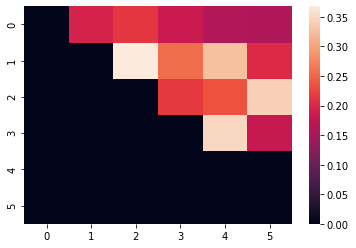

In [14]:

import numpy as np
annotators = ["anno{0}".format(i) for i in range(17)]
annotators= "anno0 anno2 anno3 anno10 anno13 anno14".split()

disagrees_df = np.array([[disagrees[i][j]/(agrees[i][j] + disagrees[i][j] + 1) for j in annotators] for i in annotators])
sns.heatmap(data=disagrees_df)


In [15]:
agrees_total = 0
for k, v in agrees.items():
    agrees_total += sum(v.values())
disagrees_total = 0
for k, v in disagrees.items():
    disagrees_total += sum(v.values())

In [16]:
print(agrees_total, disagrees_total)

13320 5316


In [17]:
for anno1, annos in agrees.items():
    for anno2, count in annos.items():
        print(anno1, anno2, count, disagrees[anno1][anno2])

anno0 anno7 206 110
anno0 anno9 602 170
anno0 anno3 1487 405
anno0 anno13 727 141
anno0 anno12 364 172
anno0 anno10 1065 239
anno0 anno2 1115 269
anno0 anno4 161 39
anno0 anno8 489 179
anno0 anno14 427 81
anno0 anno15 86 18
anno7 anno9 95 101
anno7 anno8 108 120
anno7 anno10 85 67
anno3 anno13 217 67
anno3 anno12 121 79
anno3 anno10 602 166
anno3 anno8 110 50
anno3 anno16 46 26
anno3 anno9 216 76
anno3 anno14 184 96
anno9 anno10 154 38
anno9 anno12 90 66
anno9 anno14 72 52
anno2 anno3 857 499
anno2 anno10 426 146
anno2 anno14 118 30
anno2 anno16 103 57
anno2 anno13 266 130
anno2 anno12 84 96
anno2 anno8 82 50
anno2 anno11 137 55
anno2 anno9 23 17
anno2 anno6 114 114
anno10 anno13 810 434
anno10 anno14 85 19
anno10 anno16 108 64
anno10 anno15 113 47
anno10 anno12 46 46
anno10 anno11 84 56
anno1 anno10 209 59
anno1 anno14 101 47
anno1 anno3 18 26
anno1 anno12 35 57
anno1 anno7 41 31
anno8 anno9 41 19
anno8 anno10 116 56
anno8 anno16 112 60
anno8 anno14 134 50
anno5 anno13 186 178
anno13 

In [18]:
for k, v in total_sentence_count.items():
    print(k, v)

anno12 382
anno10 1341
anno2 2296
anno13 999
anno3 636
anno8 200
anno14 154
anno9 160
anno0 34
anno7 30
